# Signatures for Paths of Persistence Diagrams

This notebook will demonstrate how to use the functions in this repository to compute signatures for paths of persistence diagrams using the moment feature map for static persistence diagrams. Following the numerical experiment in the paper, we will consider swarming behavior of a multi-agent system, simulated using the 3D D'Orsogna model.

In [39]:
# Import libraries
using DifferentialEquations
using Eirene
using Distributions
using Plots
using Dates
include("OtherFunctions.jl")
include("PathSignatures.jl")

dsignature_MMDu (generic function with 1 method)

In [2]:
# GIF folder
gif_folder = "swarm_gifs/"
if !isdir(gif_folder)
    mkdir(gif_folder);
end

## 1. Perform D'Orsogna model simulations

First, we will generate swarms by solving the differential equations from the 3D D'Orsogna model. This will be done using the DifferentialEquations library. We will generate two swarms to consider.  

The initial positions of the agents will be uniformly distributed in the cube [-1,1]^3, and each component of the initial velocity will be normally distributed with mean 1 and variance 1.  

The DifferentialEquations library solves the system of ODEs with adaptive timestepping, and we will use the built-in interpolator to obtain the solution at the given time grid (trange).  

**Note:** Each simulation may take several minutes to complete.

In [3]:
# Initialize the array to store swarm data
# Each simulation will be stored as a 3D (3, N, numT)-array
P = Array{Array{Float64, 3}, 1}(undef, 2)

# Set fixed parameters
alpha = 1.0 # self-propulsion
beta = 0.5 # drag
Ca = 1 # strength of attractive force
la = 1 # characteristic length of attractive force
m = 1 # mass
N = 100 # number of agents

numT = 200 # number of time steps in the discretized solution
endT = 200.0 # time to end the simulation

tspan = (0, endT) # time interval for input into ODE function
trange = range(0, stop=endT, length=numT) # discretized times

0.0:1.0050251256281406:200.0

In [4]:
# First simulation
C = 0.71 # ratio between interaction strengths
l = 0.65 # ratio between characteristic lengths

# Set initial conditions
u0 = rand(Uniform(-1,1),6*N)

for i = 1:N
    u0[6*(i-1)+4:6*(i-1)+6] = randn(3).+1
end

# Solve ODE
params = [alpha; beta; C; Ca; l; la; m; N]
prob = ODEProblem(dorsogna3d, u0, tspan, params)
sol = solve(prob)

# Discretize solution 
sol_interp = hcat(sol(trange).u...)

# Extract position data from the solution
curP = zeros(3, N, numT)
for i = 1:N
    for j = 1:numT
        curP[1,i,j] = sol_interp[6*(i-1)+1, j]
        curP[2,i,j] = sol_interp[6*(i-1)+2, j]
        curP[3,i,j] = sol_interp[6*(i-1)+3, j]
    end
end

# Store in P array
P[1] = curP;

In [5]:
# Second simulation
C = 0.6 # ratio between interaction strengths
l = 0.3 # ratio between characteristic lengths

# Set initial conditions
u0 = rand(Uniform(-1,1),6*N)

for i = 1:N
    u0[6*(i-1)+4:6*(i-1)+6] = randn(3).+1
end

# Solve ODE
params = [alpha; beta; C; Ca; l; la; m; N]
prob = ODEProblem(dorsogna3d, u0, tspan, params)
sol = solve(prob)

# Discretize solution 
sol_interp = hcat(sol(trange).u...)

# Extract position data from the solution
curP = zeros(3, N, numT)
for i = 1:N
    for j = 1:numT
        curP[1,i,j] = sol_interp[6*(i-1)+1, j]
        curP[2,i,j] = sol_interp[6*(i-1)+2, j]
        curP[3,i,j] = sol_interp[6*(i-1)+3, j]
    end
end

# Store in P array
P[2] = curP;

┌ Info: Saved animation to 
│   fn = /Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/swarm1_22_20_38.gif
└ @ Plots /Users/darrick/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/swarm1_22_20_38.gif")
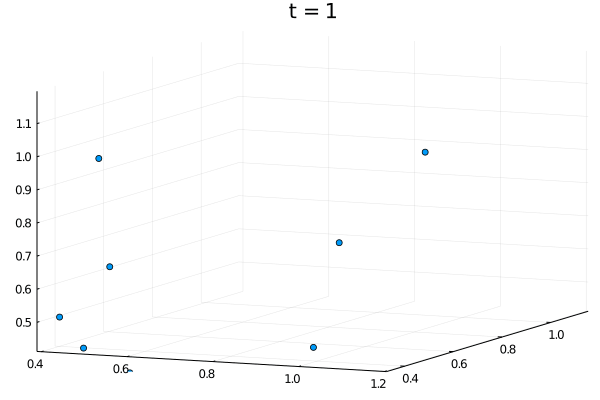

In [6]:
# Visualize swarm 1
s = 1

# Find max and min in each coordinate
bnd = zeros(3,2)
for i = 1:3
    bnd[i,1] = minimum(P[s][i,:,20:end])
    bnd[i,2] = maximum(P[s][i,:,20:end])
end

anim = @animate for tt = 1:numT
    plot(P[s][1,:,tt], P[s][2,:,tt], P[s][3,:,tt], seriestype=:scatter, title=string("t = ", tt), xlim=(bnd[1,1], bnd[1,2]), ylim=(bnd[2,1], bnd[2,2]), zlim=(bnd[3,1], bnd[3,2]), legend=false)
end
gif(anim, string(gif_folder, "swarm1_", Dates.format(now(), "HH_MM_SS"),".gif"), fps=10)


┌ Info: Saved animation to 
│   fn = /Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/swarm2_22_20_52.gif
└ @ Plots /Users/darrick/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/swarm2_22_20_52.gif")
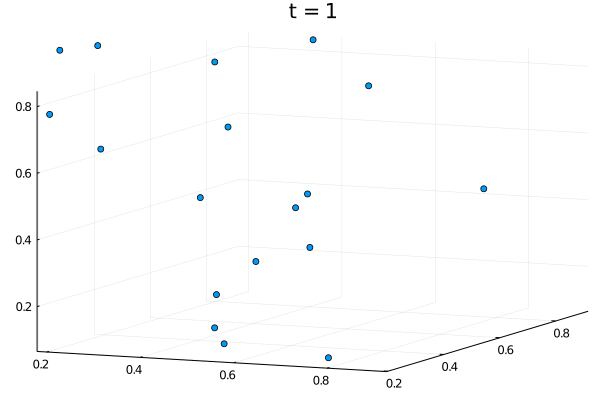

In [7]:
# Visualize swarm 2
s = 2

# Find max and min in each coordinate
bnd = zeros(3,2)
for i = 1:3
    bnd[i,1] = minimum(P[s][i,:,20:end])
    bnd[i,2] = maximum(P[s][i,:,20:end])
end

anim = @animate for tt = 1:numT
    plot(P[s][1,:,tt], P[s][2,:,tt], P[s][3,:,tt], seriestype=:scatter, title=string("t = ", tt), xlim=(bnd[1,1], bnd[1,2]), ylim=(bnd[2,1], bnd[2,2]), zlim=(bnd[3,1], bnd[3,2]), legend=false)
end
gif(anim, string(gif_folder, "swarm2_", Dates.format(now(), "HH_MM_SS"),".gif"), fps=10)


## 2. Compute Persistent Homology

We use the Eirene library to compute persistent homology up to dimension d=2, which is stored in B0, B1 and B2.  

<code>B0[s]</code> stores the time-varying B0 persistence diagram of swarm s</code>.  
* <code>B0[s]</code> is a 1D array of length <code>numT</code> of 2D arrays  
* <code>B0[s][t]</code> is the B0 persistence diagram of swarm <code>s</code> at time <code>t</code>  
* <code>B0[s][t]</code> is an (n,2)-array, where <code>n</code> is the number of points in the persistence diagram, and the two coordinates correspond to birth/death coordinates.  

B1 and B2 are stored similarly. We also compute the Betti curves for both swarms at every time point; this is stored in BE.  

<code>BE[s]</code> stores the time-varying Betti curve of swarm <code>s</code>.  
* <code>BE[s]</code> is a 1D array of length <code>numT</code> of 2D arrays  
* <code>BE[s][t]</code> is the Betti curve of swarm <code>s</code> at time <code>t</code>  
* <code>BE[s][t]</code> is a (numEPS, 3)-array, where numEPS is the number of points in the epsilon discretization, and the three coordinates correspond to the B0, B1 and B2 betti curves.

In [22]:
# Initialize arrays to store points in persistence diagram
B0 = Array{Array{Array{Float64, 2}, 1}, 1}(undef, 2)
B1 = Array{Array{Array{Float64, 2}, 1}, 1}(undef, 2)
B2 = Array{Array{Array{Float64, 2}, 1}, 1}(undef, 2)

# Compute persistent homology at every time step for both swarms
for s = 1:2
    
    # Initialize arrays for current swarm
    curB0 = Array{Array{Float64, 2},1}(undef, numT)
    curB1 = Array{Array{Float64, 2},1}(undef, numT)
    curB2 = Array{Array{Float64, 2},1}(undef, numT)
    
    for t = 1:numT
        C = eirene(P[s][:,:,t], model="pc", maxdim=2)
        curB0[t] = barcode(C, dim=0)
        curB0[t] = curB0[t][1:end-1,:] # remove the bar with infinite lifetime
        curB1[t] = barcode(C, dim=1)
        curB2[t] = barcode(C, dim=2)
    end
    
    B0[s] = curB0
    B1[s] = curB1
    B2[s] = curB2
end

In [23]:
# Compute the Betti curves
BE = Array{Array{Array{Float64, 2}, 1}, 1}(undef, 2)

# Initialize the discretization of the epsilon parameter for betti curves
tp = 10 .^(range(-4, stop=0, length=200))

# Compute the Betti curves at each time step
for s = 1:2
    curBE = Array{Array{Float64, 2},1}(undef, numT)
    
    for t = 1:numT
        curB = [B0[s][t], B1[s][t], B2[s][t]]
        curBE[t] = betti_embedding(curB, tp)
    end
    
    BE[s] = curBE
end

### Visualizing the time-varying persistence diagrams

The following generate animations of the time-varying persistence diagrams as well as the betti curves.  
* All persistence diagrams are shown in birth/lifetime coordinates  
* B0 is shown as a histogram of lifetimes, since the birthtimes are all 0  
* The B0 betti curve is scaled by 1/5 and the B2 betti curve is scaled by 5 for visualization purposes

┌ Info: Saved animation to 
│   fn = /Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/PD_23_06_44.gif
└ @ Plots /Users/darrick/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/darrick/Documents/school/projects/paths-of-persistence-diagrams/paths-of-persistence-diagrams/swarm_gifs/PD_23_06_44.gif")
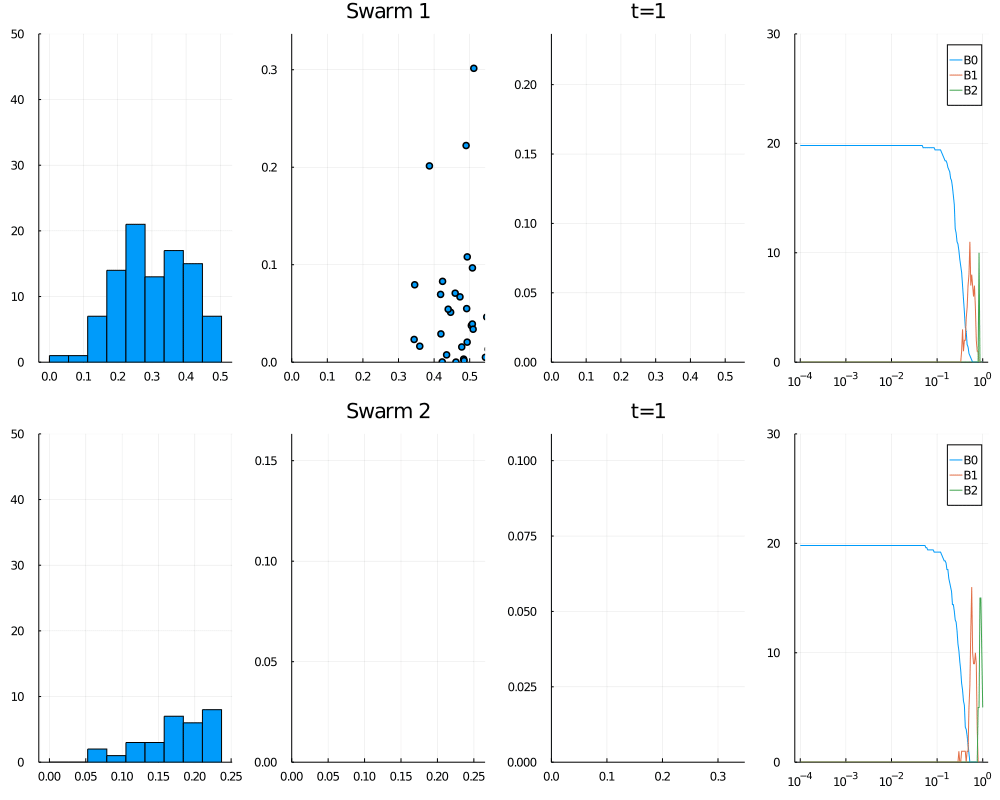

In [36]:
# Visualize the time-varying persistence diagrams for both swarm

# Find max birth/lifetime for H0, H1, H2 PDs for plot bounds
bnd = zeros(2,2,3)
for s = 1:2
    for t = 3:numT
        bnd[s,1,1] = maximum([maximum(B0[s][t][:,1]), bnd[s,1,1]])
        bnd[s,1,2] = maximum([maximum(B1[s][t][:,1]), bnd[s,1,2]])
        if !isempty(B2[s][t])
            bnd[s,1,3] = maximum([maximum(B2[s][t][:,1]), bnd[s,1,3]])
        end
        
        bnd[s,2,1] = maximum([maximum(B0[s][t][:,2]-B0[s][t][:,1]), bnd[s,2,1]])
        bnd[s,2,2] = maximum([maximum(B1[s][t][:,2]-B1[s][t][:,1]), bnd[s,2,2]])
        if !isempty(B2[s][t])
            bnd[s,2,3] = maximum([maximum(B2[s][t][:,2]-B2[s][t][:,1]), bnd[s,2,3]])
        end
    end
end
b0_bins1 = collect(range(0, stop=bnd[1,2,1], length = 10))
b0_bins2 = collect(range(0, stop=bnd[2,2,1], length = 10))
hmax = 50
BEmax = 30

anim = @animate for T = 1:numT
    l = @layout [a b c d; e f g h]
    s = 1
    p1 = histogram(B0[s][T][:,2], bins = b0_bins1, legend= false, ylim=(0, hmax))
    p2 = plot(B1[s][T][:,1], B1[s][T][:,2] - B1[s][T][:,1], legend= false, seriestype=:scatter, xlim=(0, bnd[s,1,2]), ylim=(0, bnd[s,2,2]), title=string("Swarm 1"))
    p3 = plot(B2[s][T][:,1], B2[s][T][:,2] - B2[s][T][:,1], legend= false, seriestype=:scatter, xlim=(0, bnd[s,1,3]), ylim=(0, bnd[s,2,3]), title=string("t=", T))
    p4 = plot(tp, BE[s][T][:,1]/5, ylim =(0, BEmax), xscale=:log10, labels = "B0")
    plot!(tp, BE[s][T][:,2],ylim=(0,BEmax), xscale=:log10, labels = "B1")
    plot!(tp, BE[s][T][:,3]*5,ylim=(0,BEmax), xscale=:log10, labels = "B2")

    s = 2
    p5 = histogram(B0[s][T][:,2], bins = b0_bins2, legend= false, ylim=(0, hmax))
    p6 = plot(B1[s][T][:,1], B1[s][T][:,2] - B1[s][T][:,1], legend= false, seriestype=:scatter, xlim=(0, bnd[s,1,2]), ylim=(0, bnd[s,2,2]), title=string("Swarm 2"))
    p7 = plot(B2[s][T][:,1], B2[s][T][:,2] - B2[s][T][:,1], legend= false, seriestype=:scatter, xlim=(0, bnd[s,1,3]), ylim=(0, bnd[s,2,3]), title=string("t=", T))
    p8 = plot(tp, BE[s][T][:,1]/5, ylim =(0, BEmax), xscale=:log10, labels = "B0")
    plot!(tp, BE[s][T][:,2],ylim=(0,BEmax), xscale=:log10, labels = "B1")
    plot!(tp, BE[s][T][:,3]*5,ylim=(0,BEmax), xscale=:log10, labels = "B2")
     
    plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = l, size = (1000, 800))
end
gif(anim, string(gif_folder, "PD_", Dates.format(now(), "HH_MM_SS"),".gif"), fps=10)

## 3. Computing the Moment Map

Here, we will compute the truncated moment map for each persistence diagram to obtain a path of moments.  
* Moments are computed for B0, B1 and B2 independently  
* We only compute the pure lifetime moments for B0 since the birth time for all points is 0  

Each path of moments is stored in <code>M</code>.  
* <code>M[s]</code> is a (numT, numMoments)-array, where numMoments is the total number of moments.

In [37]:
# Set moment map parameters
moment_trunc = 6 # Degree to truncate moments at

# Compute the number of moments
numMoments = moment_trunc + 2*moment_trunc*(moment_trunc+1)/2

48.0

In [38]:
M = Array{Array{Float64, 2},1}(undef, 2)

for s = 1:2
    
    # Set the third argument to "true" to only compute the lifetime moments
    M0 = moment_map(B0[s], moment_trunc, true)
    M1 = moment_map(B1[s], moment_trunc, false)
    M2 = moment_map(B2[s], moment_trunc, false)
    
    # Concatenate and store in M
    M[s] = hcat(M0, M1, M2)
end

## 4. The path signature

Here, we will show how to use the PathSignatures.jl package to compute individual signatures as well as the signature kernel.  

First, we will start by computing an individual discrete signature with the <code>dsignature()</code> function. The inputs are:  
* <code>P</code>: a path as a (numT, N)-array, where N is the number of coordinates.  
* <code>sig_trunc</code>: the signature truncation level. 
* <code>dtype</code>: the type of data; in most cases we set this to "R", which corresponds to Euclidean-valued data.

The output is stored in <code>S</code>.  
* <code>S[k]</code> is a k-dimensional array storing the k<sup>th</sup>-level of the signature.  
* For example, to access the signature with respect to multi-index (3,5,8,1), we can use <code>S[4][3,5,8,1]</code>



In [44]:
# Computing an individual signature

# Set parameters
sig_trunc = 4 # Signature truncation level

# Compute the discrete signature of the path of moments for swarm 1
S = dsignature(M[1], sig_trunc, "R")

# The signature with respect to multi-index (3,5,8,1)
S[4][3,5,8,1]

2.4131529154404725

### Signature kernel

For many applications, we wish to compute the *normalized signature kernel*, which is the inner product between signatures of different paths. We can compute this using the <code>dsignature_kernel()</code> function. The inputs are:  
* <code>P1, P2</code>: two paths as a (numT1, N)-array and a (numT2, N)-array, where N is the number of coordinates; the number of time points can vary.  
* <code>sig_trunc</code>: the signature truncation level. 
* <code>dtype</code>: the type of data; in most cases we set this to "R", which corresponds to Euclidean-valued data.

In [57]:
# Computing normalized signature kernel between two paths

# Set parameters
sig_trunc = 12
sig_kernel = dsignature_kernel(M[1], M[2], sig_trunc, "R")

7.761164586883899

We can also compute this directly from the path of persistence diagrams, using the <code>moment_kernel()</code> function from OtherFunctions.jl. The inputs for <code>moment_kernel()</code> are:
* <code>PD1, PD2</code>: two arrays of persistence diagrams up to dimension d. The type of the expected input is a 1D array of 2D arrays.

In [61]:
# Store all persistence diagrams in one object
B = Array{Array{Array{Array{Float64, 2}, 1}, 1}, 1}(undef, 2)

for s = 1:2
    curB = Array{Array{Array{Float64, 2}, 1}, 1}(undef, numT)
    for t = 1:numT
        curB[t] = [B0[s][t], B1[s][t], B2[s][t]]
    end
    B[s] = curB
end

In [64]:
# Example usage of moment_kernel()
mkernel = moment_kernel(B[1][1], B[1][5])

10047.530789356848

In <code>dsignature_kernel()</code>, when a kernel function is passed to <code>dtype</code>, it uses a kernelized version of the algorithm, in which it computes the signature kernel by first applying the kernel given in <code>dtype</code>. The expected input for the paths <code>P1</code> and <code>P2</code> are 1D arrays of objects which can be passed to the kernel function in <code>dtype</code>.

In [65]:
# We pass the function moment_kernel() to dtype
# The input paths are the paths of persistence diagrams B[1] and B[2]
sig_kernel = dsignature_kernel(B[1], B[2], sig_trunc, moment_kernel)

7.7611638021797855

### Signature kernel matrix

In order to use kernel classification or regression methods, one can precompute the kernel matrix. This is the approach used for the kernel support vector regression performed in the paper. The signature kernel matrix is computed using the <code>dsignature_kernel_matrix()</code> function. The inputs are:  
* <code>BP1</code>: a batch of paths passed as a 1D array of paths
* <code>BP2</code>: EITHER: another batch of paths passed as a 1D array of paths
    * OR: an empty array <code>[]</code>, which uses BP1 as BP2
* <code>sig_trunc</code>: signature truncation level
* <code>dtype</code>: EITHER: "R" for Euclidean valued data
    * OR: a kernel function

In [63]:
# Set parameters
sig_trunc = 12

# Compute normalized kernel matrix
K = dsignature_kernel_matrix(M, [], sig_trunc, "R")

2×2 Array{Float64,2}:
 8.0      7.76116
 7.76116  8.0

In [ ]:
# We can also use the kernelized version of this
K = dsignature_kernel_matrix(B, [], sig_trunc, moment_kernel)